In [1]:
#Enclosed mass (virial mass in Msun, concentration parameter) in Msun
def mass_nfw(r, mvir, cvir):
    
    rv = (mvir/((4/3) * pi * fac * rhocrit))**(1/3)
    
    rs = rv / cvir
    
    rhos = rhocrit*delc(cvir)
    
    return 4 * pi *  rhos * rs**3 * (log((r + rs) / rs) + rs/(r + rs) - 1) 

In [2]:
import numpy as np
from numpy import pi, log

In [3]:
class Galaxy():
    """
    Derive a dark matter density profile from a galaxy rotation curve

    Args:
        mvir (float): galaxy virial mass (Msun)
        cvir (float): dark matter concentration parameter (Msun)
    """

    def __init__(self, mvir, cvir, data_vel, data_err, data_r):

        #Define constants
        self.h = 0.678 #Gaia 2016
        self.G = 6.67430e-11
        self.Msun = 1.98847e30
        self.kpc = 3.0856775814913673e19
        self.fac = 102

        self.rhocrit = 3*(100*self.h/(self.kpc))**2/(8*np.pi*self.G) * self.kpc**3 / self.Msun

        # Data arrays
        self.data_vel = data_vel # Velocity
        self.data_err = data_err # Velocity errors
        self.data_r = data_r # Radii

        self.mvir = mvir
        self.cvir = cvir

    def delc(self):
        return (self.fac/3)*self.cvir**3/(np.log(1+self.cvir)-self.cvir/(1+self.cvir))

    def rho_nfw(self):
        #NFW density (virial mass in Msun, concentration parameter)
    
        rv = (self.mvir/((4/3) * np.pi * self.fac * self.rhocrit))**(1/3) 
        rs = rv / self.cvir
        rhos = self.rhocrit*self.delc()
    
        return rhos/((self.data_r/rs)*(1.+(self.data_r/rs))**2.)

    def mass_nfw(self):
        #Enclosed mass (virial mass in Msun, concentration parameter) in Msun
    
        rv = (self.mvir/((4/3) * np.pi * self.fac * self.rhocrit))**(1/3)
        rs = rv / self.cvir
        rhos = self.rhocrit*self.delc()
    
        return 4 * np.pi * rhos * rs**3 * (np.log((self.data_r + rs) / rs) + rs/(self.data_r + rs) - 1) 
    
    def log_like(self, log_m_h, c):
        '''
        Calculate log-likelihood using the data and NFW parameters (c, log10(M_h))
        '''

        # Calculate enclosed mass array with NFW profile
        enclosed_mass = mass_nfw(self.data_r, 10**log_m_h, c)
        # Calculate predicted velocity from v^2 = GM/r
        pred_vel = np.sqrt(self.G * enclosed_mass / self.data_err)

        # Calculate log-likelihood
        llh = -1/2 * np.sum(((self.data_vel - pred_vel) / self.data_err) ** 2)

        return llh

    def ptform(self, x):
        '''
        Prior transform.
        '''

        # Make sure x is a numpy array
        x = np.array(x)

        # Transform x[0] (log_m_h) to range 6-13 in log(M/M_sun)
        x[0] = (13 - 6) * x[0] + 6
        # Transform x[1] (c) to range 1-50
        x[1] = (50 - 1) * x[1] + 1

        # Return transformed x
        return x

In [6]:
#Example
rbin = np.arange(0,40,1)
c = 5.
m = 1.
gal = Galaxy(m, c, data_vel=1, data_err=1, data_r=rbin)
mass_nfw = gal.mass_nfw()


Text(0, 0.5, '$M_{NFW}$')

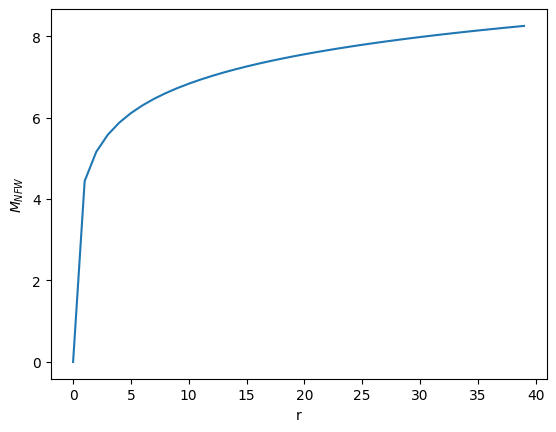

In [7]:
import matplotlib.pyplot as plt
plt.plot(rbin, mass_nfw)
plt.xlabel('r')
plt.ylabel('$M_{NFW}$')